# Flower classifier 2 layers

_Author: Baccega Sandro_

In this notebook we will classify Oxford's `102 Category Flower Dataset` that can be found [here](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html).

Another required asset to run this code is `Oxford-102_Flower_dataset_labels.txt` from JosephKJ that can be found [here](https://gist.github.com/JosephKJ/94c7728ed1a8e0cd87fe6a029769cde1), this external file contains the flowers names.

---


## Imports and constants


In [1]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import torch
import shutil
import os
import tqdm
import matplotlib.pyplot as plt
import skimage.io as skio
from sklearn.metrics import confusion_matrix
import seaborn as sn
from tabulate import tabulate
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, models, datasets
from torchvision.models import ResNet18_Weights

# --- CONSTANTS AND HYPERPARAMETERS ---

CHOOSEN_MODEL = 1
SEED = 151836
DATASET_SPLIT = 0.9             # Get 80% of dataset for training, the rest for testing/validation
TESTING_VALIDATION_SPLIT = 0.2  # Get 50% of testing dataset for validation, the rest for testing

BATCH_SIZE = 64
N_EPOCHS = 33
HIDDEN_LAYERS_OUTPUT_CHANNELS = [8, 16, 24, 32]
CROPPED_IMAGES_SIZE = 256
LEARNING_RATE = 0.001

# Assets location

RAW_IMAGE_LABELS_MAT_FILE = "assets/imagelabels.mat"
RAW_DATASET_LABELS_FILE = "assets/Oxford-102_Flower_dataset_labels.txt"
RAW_DATASET_IMAGES_FOLDER = "assets/jpg"
RAW_SEGMENTED_IMAGES_FOLDER = "assets/segmim"

# Data folder location

DATASET_IMAGES_FOLDER = "data/images"

# Setting seed
torch.manual_seed(SEED)

# Set device to use for computations
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = (
#     "cuda"
#     if torch.cuda.is_available()
#     else ("mps" if torch.backends.mps.is_available() else "cpu")
# )

print(f"-----\nPyTorch version: {torch.__version__}\nDevice: {device}\n-----")


-----
PyTorch version: 1.13.0.dev20220608
Device: cpu
-----


## Creating the sorted data folder


In [2]:
metadata = pd.DataFrame()
metadata['images'] = sorted(os.listdir(RAW_DATASET_IMAGES_FOLDER))
metadata["labels"] = loadmat(RAW_IMAGE_LABELS_MAT_FILE)["labels"][0] - 1 
metadata['labels'] = metadata['labels'].astype(str)

# print(metadata)

groups = metadata.groupby("labels")["images"].apply(list)

# Creating data folder (ImageFolder dataset)
# If data folder exists, do not create images folder
# if not os.path.isdir(DATASET_IMAGES_FOLDER):
#     print("Creating data folder")
#     os.mkdir(DATASET_IMAGES_FOLDER)

#     for category, images in groups.items():
#         os.mkdir("{}/{}".format(DATASET_IMAGES_FOLDER, category))
#         for image in images:
#             shutil.copyfile(
#                 "{}/{}".format(RAW_DATASET_IMAGES_FOLDER, image),
#                 "{}/{}/{}".format(DATASET_IMAGES_FOLDER, category, image),
#             )

#     print("Done - data folder creation")
# else:
#     print("Skipping - data folder creation")


# Creating category to label reference
rawLabelReferenceData = np.loadtxt(RAW_DATASET_LABELS_FILE, dtype="str", delimiter="\n")
labelReferenceData = list(map(lambda str: str[2:-1], rawLabelReferenceData))

i = 0
labelReference = {}

for category, images in groups.items():
    labelReference[category] = labelReferenceData[i]
    i += 1

print("Done - label reference creation")
# print(labelReference)


Done - label reference creation


## Creating the datasets


Train dataset size: 1020
Validation dataset size: 1020
Test dataset size: 6149


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

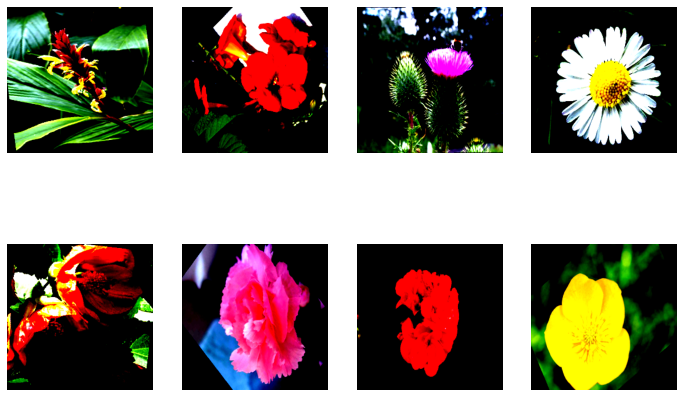

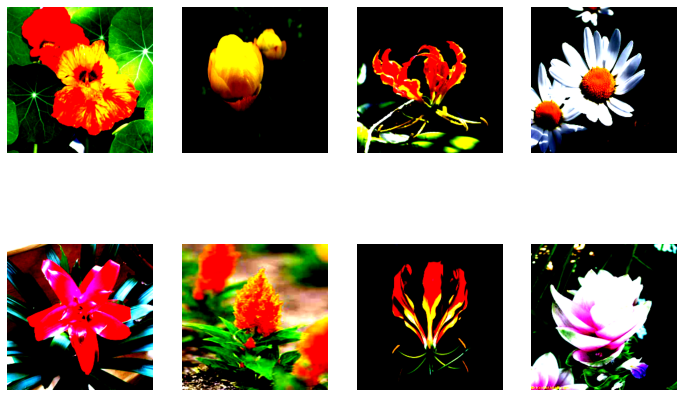

In [3]:
class FlowerDateset(Dataset):
    def __init__(self, metadata, transform=None):
        self.metadata = metadata
        self.transform = transform

    def __getitem__(self, index):
        image_path = self.metadata.iloc[index, 0]
        image = skio.imread("{}/{}".format(RAW_DATASET_IMAGES_FOLDER, image_path))
        label = torch.tensor(int(self.metadata.iloc[index, 1]))
        # label = F.one_hot(label, num_classes=102)
        # label = label.float()
        if self.transform:
            image = self.transform(image)

        return (image, label)

    def __len__(self):
        return len(self.metadata)


transform_train = transforms.Compose(
    [
        # transforms.ToPILImage(),
        transforms.RandomRotation(45),
        transforms.RandomHorizontalFlip(),
        transforms.Resize((CROPPED_IMAGES_SIZE, CROPPED_IMAGES_SIZE)),
        # transforms.RandomCrop(CROPPED_IMAGES_SIZE),
        # transforms.AutoAugment(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)
transform_valid = transforms.Compose(
    [
        # transforms.ToPILImage(),
        # transforms.RandomRotation(45),
        # transforms.RandomHorizontalFlip(),
        transforms.Resize((CROPPED_IMAGES_SIZE, CROPPED_IMAGES_SIZE)),
        # transforms.RandomCrop(CROPPED_IMAGES_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

dataset_train = datasets.Flowers102(root="data/train", download=True, transform=transform_train)
dataset_validation = datasets.Flowers102(root="data/validation", download=True, transform=transform_valid, split="val")
dataset_test = datasets.Flowers102(root="data/test", download=True, transform=transform_valid, split="test")

# dataset_train = datasets.ImageFolder("data/images", transform=transform_train)
# dataset_valid = datasets.ImageFolder("data/images", transform=transform_valid)
# dataset = FlowerDateset(metadata, transform=transform)

# train_size = int(len(dataset_train) * DATASET_SPLIT)
# validation_test_size = len(dataset_train) - train_size

# indices = torch.randperm(len(dataset_train))
# train_dataset = torch.utils.data.Subset(dataset_train, indices[:-validation_test_size])
# validation_test_dataset = torch.utils.data.Subset(
#     dataset_valid, indices[-validation_test_size:]
# )

# validation_size = int(len(validation_test_dataset) * TESTING_VALIDATION_SPLIT)
# test_size = len(validation_test_dataset) - validation_size

# indices = torch.randperm(len(validation_test_dataset))
# dataset_validation = torch.utils.data.Subset(validation_test_dataset, indices[:-test_size])
# test_dataset = torch.utils.data.Subset(validation_test_dataset, indices[-test_size:])


# train_dataset, validation_test_dataset = data.random_split(
#     dataset_train, [train_set_size, validation_set_size + test_set_size]
# )
# dataset_validation, test_dataset = data.random_split(
#     validation_test_dataset, [validation_set_size, test_set_size]
# )


# train_dataset = torch.utils.data.Subset(train_dataset, indices=torch.arange(train_set_size))
# dataset_validation = torch.utils.data.Subset(dataset_validation, indices=torch.arange(validation_set_size))
# test_dataset = torch.utils.data.Subset(test_dataset, indices=torch.arange(test_set_size))

# train_dataset.dataset.transform = transform_train
# dataset_validation.dataset.transform = transform_valid
# test_dataset.dataset.transform = transform_valid

train_dataloader = data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = data.DataLoader(
    dataset_validation, batch_size=BATCH_SIZE, shuffle=True
)
test_dataloader = data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

print("Train dataset size: {}".format(len(dataset_train)))
print("Validation dataset size: {}".format(len(dataset_validation)))
print("Test dataset size: {}".format(len(dataset_test)))

n_rows = 2
n_cols = 4

for x, y in train_dataloader:
    x = x.to(device)
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 8))
    for i in range(n_rows):
        for j in range(n_cols):
            ax[i, j].imshow(x[(i * n_cols) + j].cpu().permute(1, 2, 0))
            ax[i, j].axis("off")
            # ax[i, j].set_title(labelReference[label])
    break
n_rows = 2
n_cols = 4

for x, y in validation_dataloader:
    x = x.to(device)
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 8))
    for i in range(n_rows):
        for j in range(n_cols):
            ax[i, j].imshow(x[(i * n_cols) + j].cpu().permute(1, 2, 0))
            ax[i, j].axis("off")
            # ax[i, j].set_title(labelReference[label])
    break


## Creating the model

Here we create our CNN model with 2 simple layers or use the ResNet18 model.

We use a kernel_size=(3,3), stride=(1,1) and padding=(1,1) in order to have a same convolution (manteins image size).

We use a MaxPool2d to reduce the size of the network by half efficiently.

We use a Linear to create the last fully connected layer.  

We use the Adam optimizer and the CrossEntropyLoss as our loss function.


In [4]:
class My2LayerCNN(nn.Module):
    def __init__(
        self,
        num_in_channels=3,
        num_out_channels=HIDDEN_LAYERS_OUTPUT_CHANNELS,
        img_width=CROPPED_IMAGES_SIZE,
        img_height=CROPPED_IMAGES_SIZE,
        num_classes=102,
    ):
        super(My2LayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=num_in_channels,
            out_channels=num_out_channels[0],
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv2 = nn.Conv2d(
            in_channels=num_out_channels[0],
            out_channels=num_out_channels[1],
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.fc = nn.Linear(
            in_features=int(img_width / 4) * int(img_height / 4) * num_out_channels[1],
            out_features=num_classes,
        )

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.fc(x.reshape(x.shape[0], -1))
        return x
class My4LayerCNN(nn.Module):
    def __init__(
        self,
        num_in_channels=3,
        num_out_channels=HIDDEN_LAYERS_OUTPUT_CHANNELS,
        img_width=CROPPED_IMAGES_SIZE,
        img_height=CROPPED_IMAGES_SIZE,
        num_classes=102,
    ):
        super(My4LayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=num_in_channels,
            out_channels=num_out_channels[0],
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv2 = nn.Conv2d(
            in_channels=num_out_channels[0],
            out_channels=num_out_channels[1],
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv3 = nn.Conv2d(
            in_channels=num_out_channels[1],
            out_channels=num_out_channels[2],
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv4 = nn.Conv2d(
            in_channels=num_out_channels[2],
            out_channels=num_out_channels[3],
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.fc = nn.Linear(
            in_features=int(img_width / 16) * int(img_height / 16) * num_out_channels[3],
            out_features=num_classes,
        )

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.fc(x.view(x.shape[0], -1))
        return x


# Load saved model
if CHOOSEN_MODEL == 0:
    model = My2LayerCNN()
    model.load_state_dict(torch.load('model.pt'))
    model.eval()
# My 2 Layer CNN model
if CHOOSEN_MODEL == 1:
    model = My2LayerCNN()
# Resnet
if CHOOSEN_MODEL == 2:
    model = My4LayerCNN()
# Resnet pretrained
if CHOOSEN_MODEL == 3:
    model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, 102)


model = model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Loss function
criterion = nn.CrossEntropyLoss()


## Train model


In [5]:
training_results_data = pd.DataFrame(
    {"Epoch": [], "Predictions": [], "Samples": [], "Accuracy": [], "Loss": []}
)

def check_accuracy(data_loader, model):
    n_corrects = 0
    n_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in data_loader:
            # Sending data to device
            x = x.to(device)
            y = y.to(device)

            # Forward propagation
            y_hat = model(x)

            # Calculate accuracy
            _, predictions = y_hat.max(1)
            n_corrects += (predictions == y).sum()
            n_samples += predictions.size(0)

        perc = (n_corrects.item() / n_samples) * 100
        return (n_corrects.item(), n_samples, perc)


if CHOOSEN_MODEL != 0: 
    model.train()
    # Tensorboard writer
    writer = SummaryWriter()
    for epoch in range(N_EPOCHS):
        running_loss = 0.0

        with tqdm.tqdm(train_dataloader, unit="batch") as tepoch:

            for index, (x, y) in enumerate(tepoch):
        
                optimizer.zero_grad()
                # Send the data to the device
                x = x.to(device)
                y = y.to(device)

                # Forward propagation
                y_hat = model(x)
                loss = criterion(y_hat, y)
                running_loss += loss

                # Backward propagation
                # Calculate derivatives for every parameters
                loss.backward()
                # Do gradient descent
                optimizer.step()
                tepoch.set_postfix(loss=loss.item())

            print(f"Epoch {epoch + 1}, loss: {running_loss}")
            n_corrects, n_samples, accuracy = check_accuracy(validation_dataloader, model)
            print(f"Accuracy: {n_corrects}/{n_samples} = {accuracy:.2f}%")
            # writer.add_figure("Confusion matrix", createConfusionMatrix(validation_dataloader, model), epoch)
            training_results_data.loc[len(training_results_data.index)] = [
                int(epoch + 1),
                int(n_corrects),
                int(n_samples),
                accuracy,
                running_loss.item(),
            ]
            writer.add_scalar("Loss/train", running_loss, epoch)
            writer.add_scalar('Accuracy/validation', accuracy, epoch)


    writer.flush()

    

    # Saving model
    torch.save(model.state_dict(), 'model.pt')

# Saving parameters
with open('model_parameters.txt', 'w') as file:
    file.write(f"CHOOSEN_MODEL = {CHOOSEN_MODEL}\n")
    file.write(f"SEED = {SEED}\n")
    file.write(f"DATASET_SPLIT = {DATASET_SPLIT}\n")
    file.write(f"TESTING_VALIDATION_SPLIT = {TESTING_VALIDATION_SPLIT}\n")
    file.write(f"BATCH_SIZE = {BATCH_SIZE}\n")
    file.write(f"N_EPOCHS = {N_EPOCHS}\n")
    file.write(f"HIDDEN_LAYERS_OUTPUT_CHANNELS = {HIDDEN_LAYERS_OUTPUT_CHANNELS}\n")
    file.write(f"CROPPED_IMAGES_SIZE = {CROPPED_IMAGES_SIZE}\n")
    file.write(f"LEARNING_RATE = {LEARNING_RATE}\n")

100%|██████████| 16/16 [00:28<00:00,  1.79s/batch, loss=4.73]


Epoch 1, loss: 139.66188049316406
Accuracy: 76/1020 = 7.45%


100%|██████████| 16/16 [00:22<00:00,  1.39s/batch, loss=3.64]


Epoch 2, loss: 63.732173919677734
Accuracy: 120/1020 = 11.76%


100%|██████████| 16/16 [00:20<00:00,  1.25s/batch, loss=3.22]


Epoch 3, loss: 51.629859924316406
Accuracy: 185/1020 = 18.14%


100%|██████████| 16/16 [00:28<00:00,  1.77s/batch, loss=2.71]


Epoch 4, loss: 43.93470764160156
Accuracy: 212/1020 = 20.78%


100%|██████████| 16/16 [00:20<00:00,  1.27s/batch, loss=1.97]


Epoch 5, loss: 37.68077087402344
Accuracy: 225/1020 = 22.06%


100%|██████████| 16/16 [00:17<00:00,  1.09s/batch, loss=2.2] 


Epoch 6, loss: 34.17576217651367
Accuracy: 244/1020 = 23.92%


100%|██████████| 16/16 [00:16<00:00,  1.02s/batch, loss=1.49]


Epoch 7, loss: 31.508474349975586
Accuracy: 249/1020 = 24.41%


100%|██████████| 16/16 [00:16<00:00,  1.03s/batch, loss=1.75]


Epoch 8, loss: 28.007728576660156
Accuracy: 257/1020 = 25.20%


100%|██████████| 16/16 [00:18<00:00,  1.13s/batch, loss=1.61]


Epoch 9, loss: 24.550983428955078
Accuracy: 282/1020 = 27.65%


100%|██████████| 16/16 [00:17<00:00,  1.10s/batch, loss=1.34]


Epoch 10, loss: 22.585805892944336
Accuracy: 293/1020 = 28.73%


100%|██████████| 16/16 [00:16<00:00,  1.03s/batch, loss=1.08]


Epoch 11, loss: 19.652048110961914
Accuracy: 298/1020 = 29.22%


100%|██████████| 16/16 [00:16<00:00,  1.03s/batch, loss=1.42]


Epoch 12, loss: 18.855215072631836
Accuracy: 289/1020 = 28.33%


100%|██████████| 16/16 [00:16<00:00,  1.06s/batch, loss=1.11] 


Epoch 13, loss: 16.584291458129883
Accuracy: 302/1020 = 29.61%


100%|██████████| 16/16 [00:15<00:00,  1.04batch/s, loss=0.824]


Epoch 14, loss: 14.58826732635498
Accuracy: 324/1020 = 31.76%


100%|██████████| 16/16 [00:15<00:00,  1.06batch/s, loss=0.916]


Epoch 15, loss: 13.261688232421875
Accuracy: 318/1020 = 31.18%


100%|██████████| 16/16 [00:14<00:00,  1.08batch/s, loss=0.747]


Epoch 16, loss: 12.760308265686035
Accuracy: 319/1020 = 31.27%


100%|██████████| 16/16 [00:15<00:00,  1.02batch/s, loss=0.667]


Epoch 17, loss: 11.655052185058594
Accuracy: 308/1020 = 30.20%


100%|██████████| 16/16 [00:17<00:00,  1.07s/batch, loss=0.64] 


Epoch 18, loss: 10.78471851348877
Accuracy: 324/1020 = 31.76%


100%|██████████| 16/16 [00:17<00:00,  1.11s/batch, loss=0.453]


Epoch 19, loss: 8.98480224609375
Accuracy: 305/1020 = 29.90%


100%|██████████| 16/16 [00:17<00:00,  1.06s/batch, loss=0.717]


Epoch 20, loss: 9.205127716064453
Accuracy: 326/1020 = 31.96%


100%|██████████| 16/16 [00:16<00:00,  1.05s/batch, loss=0.611]


Epoch 21, loss: 8.3887300491333
Accuracy: 320/1020 = 31.37%


100%|██████████| 16/16 [00:18<00:00,  1.13s/batch, loss=0.464]


Epoch 22, loss: 7.847171783447266
Accuracy: 319/1020 = 31.27%


100%|██████████| 16/16 [00:21<00:00,  1.32s/batch, loss=0.447]


Epoch 23, loss: 6.8947978019714355
Accuracy: 314/1020 = 30.78%


100%|██████████| 16/16 [00:13<00:00,  1.17batch/s, loss=0.29] 


Epoch 24, loss: 6.535878658294678
Accuracy: 331/1020 = 32.45%


100%|██████████| 16/16 [00:14<00:00,  1.10batch/s, loss=0.189]


Epoch 25, loss: 6.9657206535339355
Accuracy: 316/1020 = 30.98%


100%|██████████| 16/16 [00:15<00:00,  1.06batch/s, loss=0.403]


Epoch 26, loss: 6.014971733093262
Accuracy: 309/1020 = 30.29%


100%|██████████| 16/16 [00:14<00:00,  1.07batch/s, loss=0.454]


Epoch 27, loss: 6.000007629394531
Accuracy: 318/1020 = 31.18%


100%|██████████| 16/16 [00:13<00:00,  1.16batch/s, loss=0.422]


Epoch 28, loss: 5.371538162231445
Accuracy: 331/1020 = 32.45%


100%|██████████| 16/16 [00:18<00:00,  1.16s/batch, loss=0.249]


Epoch 29, loss: 5.421685218811035
Accuracy: 323/1020 = 31.67%


100%|██████████| 16/16 [00:15<00:00,  1.02batch/s, loss=0.221]


Epoch 30, loss: 5.142590045928955
Accuracy: 326/1020 = 31.96%


100%|██████████| 16/16 [00:14<00:00,  1.08batch/s, loss=0.278]


Epoch 31, loss: 4.1705145835876465
Accuracy: 331/1020 = 32.45%


100%|██████████| 16/16 [00:16<00:00,  1.02s/batch, loss=0.53] 


Epoch 32, loss: 3.69449782371521
Accuracy: 329/1020 = 32.25%


100%|██████████| 16/16 [00:16<00:00,  1.05s/batch, loss=0.104]


Epoch 33, loss: 3.5985066890716553
Accuracy: 350/1020 = 34.31%


100%|██████████| 16/16 [00:22<00:00,  1.40s/batch, loss=0.192] 


Epoch 34, loss: 3.2514965534210205
Accuracy: 329/1020 = 32.25%


100%|██████████| 16/16 [00:15<00:00,  1.04batch/s, loss=0.108]


Epoch 35, loss: 4.03788948059082
Accuracy: 319/1020 = 31.27%


100%|██████████| 16/16 [00:14<00:00,  1.08batch/s, loss=0.237] 


Epoch 36, loss: 3.399509906768799
Accuracy: 320/1020 = 31.37%


100%|██████████| 16/16 [00:13<00:00,  1.15batch/s, loss=0.295]


Epoch 37, loss: 3.440070867538452
Accuracy: 319/1020 = 31.27%


100%|██████████| 16/16 [00:13<00:00,  1.17batch/s, loss=0.14] 


Epoch 38, loss: 3.3021867275238037
Accuracy: 306/1020 = 30.00%


100%|██████████| 16/16 [00:13<00:00,  1.18batch/s, loss=0.223]


Epoch 39, loss: 3.5263192653656006
Accuracy: 300/1020 = 29.41%


100%|██████████| 16/16 [00:14<00:00,  1.12batch/s, loss=0.218] 


Epoch 40, loss: 2.6426961421966553
Accuracy: 334/1020 = 32.75%


## Results

Training/Validation results
╒═════════╤═══════════════════════╤════════════╤═══════════╕
│   Epoch │ Predictions/Samples   │ Accuracy   │      Loss │
╞═════════╪═══════════════════════╪════════════╪═══════════╡
│       1 │ 76/1020               │ 7.45%      │ 139.662   │
├─────────┼───────────────────────┼────────────┼───────────┤
│       2 │ 120/1020              │ 11.76%     │  63.7322  │
├─────────┼───────────────────────┼────────────┼───────────┤
│       3 │ 185/1020              │ 18.14%     │  51.6299  │
├─────────┼───────────────────────┼────────────┼───────────┤
│       4 │ 212/1020              │ 20.78%     │  43.9347  │
├─────────┼───────────────────────┼────────────┼───────────┤
│       5 │ 225/1020              │ 22.06%     │  37.6808  │
├─────────┼───────────────────────┼────────────┼───────────┤
│       6 │ 244/1020              │ 23.92%     │  34.1758  │
├─────────┼───────────────────────┼────────────┼───────────┤
│       7 │ 249/1020              │ 24.41%     │  31.5085

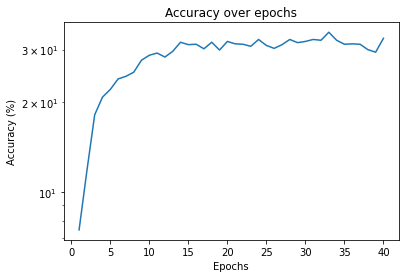

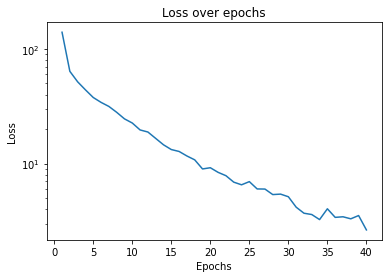

Testing results
Testing accuracy: 1816/6149 (29.53%)


In [6]:
def createConfusionMatrix(data_loader, model):
    confusion_matrix = torch.zeros((102, 102))
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(data_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1

    fig = plt.figure(figsize=(250,250))

    # confusion_matrix_np = confusion_matrix.numpy()
    # np.savetxt("confusion_matrix.csv", confusion_matrix_np, delimiter=",")
    
    class_names = list(labelReference.values())
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
    df_cm.to_csv('confusion_matrix.csv')

    heatmap = sn.heatmap(df_cm, annot=True, fmt="d")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=10)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=10)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig
    
if CHOOSEN_MODEL != 0:
    print("Training/Validation results")
    formatted_training_results_data = pd.DataFrame(
        {"Epoch": [], "Predictions/Samples": [], "Accuracy": [], "Loss": []}
    )
    for index, row in training_results_data.iterrows():
        formatted_training_results_data.loc[len(formatted_training_results_data.index)] = [
                row[0],
                f"{int(row[1])}/{int(row[2])}",
                f"{row[3]:.2f}%",
                f"{row[4]}",
            ]

    print(tabulate(formatted_training_results_data, headers = 'keys', tablefmt = 'fancy_grid', showindex="never"))

    plt.plot(training_results_data["Epoch"], training_results_data["Accuracy"])
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.yscale('log')
    # plt.grid(True)
    plt.show()

    plt.plot(training_results_data["Epoch"], training_results_data["Loss"])
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')
    # plt.grid(True)
    plt.show()

print("Testing results")
n_corrects, n_samples, accuracy = check_accuracy(test_dataloader, model)
print(f"Testing accuracy: {n_corrects}/{n_samples} ({accuracy:.2f}%)")
writer.add_figure("Confusion matrix", createConfusionMatrix(test_dataloader, model))
writer.flush()
writer.close()